In [58]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.filters import sobel,laplace

In [2]:
from PIL import Image
%matplotlib inline

In [3]:
lena = np.asarray(Image.open('lena512color.tiff'))

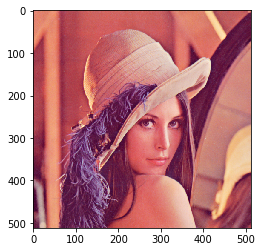

In [4]:
plt.imshow(lena)

In [55]:
lena.shape

(512, 512, 3)

In [5]:
lena = np.float32(lena / 255)

In [6]:
lena[0,0]

array([0.8862745 , 0.5372549 , 0.49019608], dtype=float32)

In [7]:
def coords_to_binary(coordinates, shape):
    nbits0 = int(math.ceil(math.log(shape[0], 2)))
    nbits1 = int(math.ceil(math.log(shape[1], 2)))
    
    bin0 = format(coordinates[0], '0' + (str(nbits0) + 'b'))
    bin1 = format(coordinates[1], '0' + (str(nbits1) + 'b'))
     
    return np.array(list(map(int, bin0 + bin1)))

In [8]:
def gen_training_binary_coords(shape, image,scale=True):
    data = np.empty((shape[0]*shape[1], int(math.log(shape[0],2)) + int(math.log(shape[1],2) + 3)))
    for i in range(shape[0]):
        for j in range(shape[1]):
            data[shape[0]*i + j][:-3] = coords_to_binary((i,j),shape)
            data[shape[0]*i + j][-3:] = image[i,j]
            
    return data

In [176]:
def gen_training_coords(shape, image, repeats=1):
    data = np.empty((shape[0]*shape[1], 2*repeats + 3))
    for i in range(shape[0]):
        for j in range(shape[1]):
            data[shape[0]*i + j][:2*repeats] = [(i - (shape[0]-1)/2)/((shape[0]-1)/2),(j - (shape[0]-1)/2)/((shape[0]-1)/2)] * repeats
            data[shape[0]*i + j][2*repeats:] = image[i,j]
            
    return data

In [206]:
train = gen_training_coords((512,512),lena,repeats=16)

In [207]:
X = train[:, :-3]
y = train[:,-3:]

In [208]:
X[0]


array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.])

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform

In [112]:
from tensorflow.math import sin as Sine
from tensorflow.math import tanh as Tanh

    

In [113]:
def ST(x):
    return Sine(Tanh(x))

In [209]:
w0 = 30
n = len(X[0])


In [168]:
def hfSin(x):
    return Sine(w0*x)

In [143]:
#bigger model
model = Sequential()
model.add(Dense(18, activation='tanh'))
model.add(Dense(18, activation=Sine))
model.add(Dense(18, activation=Sine))
model.add(Dense(18, activation=Sine))
model.add(Dense(18, activation=Sine))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

In [210]:
#long model
model = Sequential()
model.add(Dense(64, activation=hfSin, kernel_initializer=RandomUniform(minval=-1/n, maxval=1/n)))
model.add(Dense(64, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(64, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(64, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(64, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

In [211]:
from tensorflow import device
with device('/GPU:0'):
    model.fit(x=X, y=y, epochs= 500, batch_size = 4096, verbose=1)

Epoch 1/500
262144/262144 [==============================] - 5s 20us/sample - loss: 0.0177
Epoch 2/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0058
Epoch 3/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0051
Epoch 4/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0048
Epoch 5/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0047
Epoch 6/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0041
Epoch 7/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0040
Epoch 8/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0043
Epoch 9/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0039
Epoch 10/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0037
Epoch 11/500
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0040
Epoch 1

KeyboardInterrupt: 

In [151]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_194 (Dense)            multiple                  342       
_________________________________________________________________
dense_195 (Dense)            multiple                  342       
_________________________________________________________________
dense_196 (Dense)            multiple                  342       
_________________________________________________________________
dense_197 (Dense)            multiple                  342       
_________________________________________________________________
dense_198 (Dense)            multiple                  342       
_________________________________________________________________
dense_199 (Dense)            multiple                  342       
_________________________________________________________________
dense_200 (Dense)            multiple                

## batch size 4096: Activation: 5 x tanh, 1 x sigmoid. Layer sizes: 72,72,72,72,18,3

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1368      
_________________________________________________________________
dense_1 (Dense)              multiple                  5256      
_________________________________________________________________
dense_2 (Dense)              multiple                  5256      
_________________________________________________________________
dense_3 (Dense)              multiple                  5256      
_________________________________________________________________
dense_4 (Dense)              multiple                  1314      
_________________________________________________________________
dense_5 (Dense)              multiple                  57        
Total params: 18,507
Trainable params: 18,507
Non-trainable params: 0
____________________________________________________

### 10 epochs

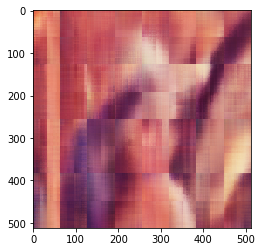

In [46]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [47]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.7013673541073433
mse with base image: 0.008710527575691128
PSNR: 20.599555400241872


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


### 100 epochs

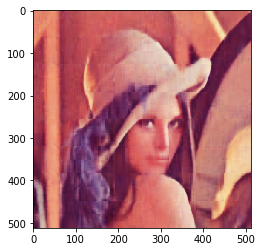

In [49]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [58]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8230638120017565
mse with base image: 0.002434255495830796
PSNR: 26.136338408117304


### 500 epochs

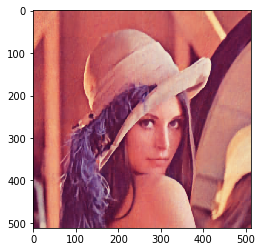

In [38]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [43]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8806554033417097
mse with base image: 0.0012772942329092281
PSNR: 28.937090486959885


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


### 10 epochs raw co-ordinates

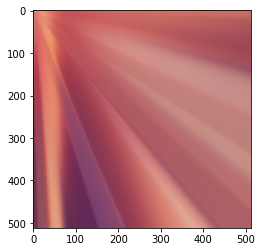

In [20]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [21]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.6934702071595149
mse with base image: 0.02264896173578103
PSNR: 16.44951701940605


### 100 epochs raw co-ordinates

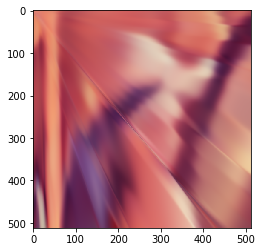

In [23]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [24]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.726219255710109
mse with base image: 0.01074051674553825
PSNR: 19.689748234467885


### 510 epochs raw co-ordinates

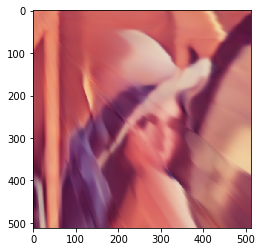

In [26]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [27]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.7716775818003986
mse with base image: 0.005415991354046373
PSNR: 22.663220376192466


### 100 epochs, co-ordinates repeated 8 times at input

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             multiple                  1224      
_________________________________________________________________
dense_19 (Dense)             multiple                  5256      
_________________________________________________________________
dense_20 (Dense)             multiple                  5256      
_________________________________________________________________
dense_21 (Dense)             multiple                  5256      
_________________________________________________________________
dense_22 (Dense)             multiple                  1314      
_________________________________________________________________
dense_23 (Dense)             multiple                  57        
Total params: 18,363
Trainable params: 18,363
Non-trainable params: 0
__________________________________________________

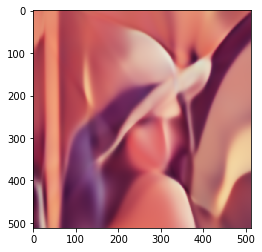

In [46]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

### 100 epochs, co-ordinates repeated 9 times

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             multiple                  1368      
_________________________________________________________________
dense_25 (Dense)             multiple                  5256      
_________________________________________________________________
dense_26 (Dense)             multiple                  5256      
_________________________________________________________________
dense_27 (Dense)             multiple                  5256      
_________________________________________________________________
dense_28 (Dense)             multiple                  1314      
_________________________________________________________________
dense_29 (Dense)             multiple                  57        
Total params: 18,507
Trainable params: 18,507
Non-trainable params: 0
__________________________________________________

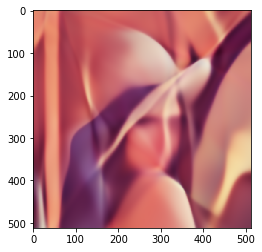

In [54]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [55]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.7771260950402522
mse with base image: 0.004701061273985977
PSNR: 23.278040881479377


### 500 epochs, co-ordinates repeated 9 times

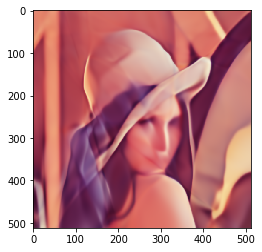

In [57]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)


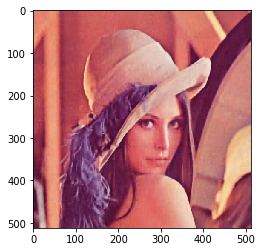

In [93]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

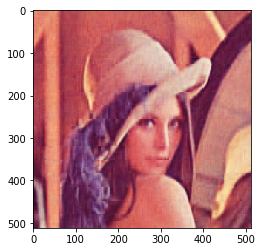

In [110]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [111]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8223913933411492
mse with base image: 0.002334471295988579
PSNR: 26.31811461664813


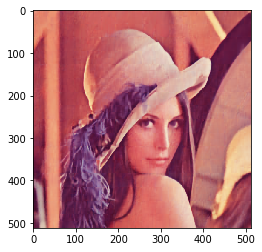

In [116]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

In [117]:
print('ssim with base image: ' + str(ssim(lena,result,multichannel=True)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8841150253435294
mse with base image: 0.0012105543644845384
PSNR: 29.17015702161541


### testing SIREN implementation

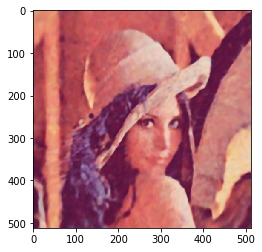

In [205]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)

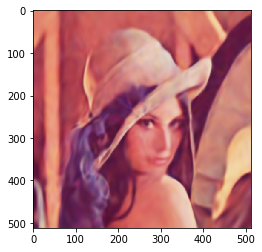

In [212]:
result = model.predict(X).reshape((512,512,3))
plt.imshow(result)